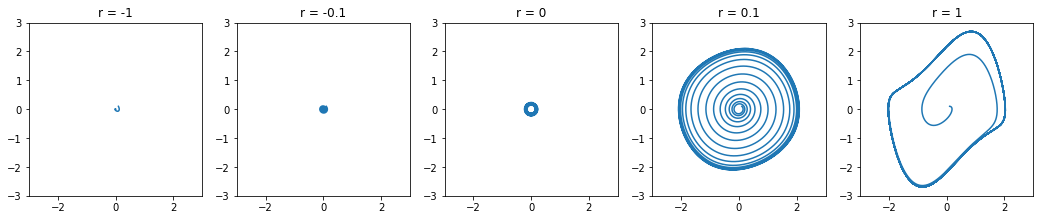

In [3]:
import matplotlib.pyplot as plt
dt = 0.01

# prepare plots
fig = plt.figure(figsize=(18,6))

def plot_phase_space():
    x = y = 0.1
    xresult = [x]
    yresult = [y]
    for t in range(10000):
        nextx = x + y * dt
        nexty = y + (-r * (x**2 - 1) * y - x) * dt
        x, y = nextx, nexty
        xresult.append(x)
        yresult.append(y)
    plt.plot(xresult, yresult)
    plt.axis('image')
    plt.axis([-3, 3, -3, 3])
    plt.title('r = ' + str(r))

rs = [-1, -0.1, 0, .1, 1]
for i in range(len(rs)):
    fig.add_subplot(1, len(rs), i + 1)
    r = rs[i]
    plot_phase_space()

In [1]:
# Analysis
from collections import defaultdict
import numpy as np
import sympy as sp
import pandas as pd
from numpy.linalg import eig, eigvals, det
from scipy.integrate import odeint
from scipy.optimize import fsolve

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Configure visualizations
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pylab.rcParams['figure.figsize'] = 14, 12
pylab.rcParams['axes.titlesize'] = 20
pylab.rcParams['axes.labelsize'] = 16
pylab.rcParams['xtick.labelsize'] = 14
pylab.rcParams['ytick.labelsize'] = 14
pylab.rcParams['legend.fontsize'] = 14
sns.set_style('ticks')
palette = ["#1E88E5", "#43A047", "#e53935", "#5E35B1", "#FFB300", "#00ACC1", "#3949AB", "#F4511E"]
sns.set_palette(palette)

In [6]:
pip install sympy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:

# Default Parameters
params0 = {'a_1':0.9, 'a_2':0.02, 'a_3':0.0, 'a_4':0.024, 'a_5':430.0, 'a_6':-7.5,
           'k':0.005, 'k_i':2283.0, 'r':10.0, 'u_R':0.4}

In [5]:
def growth_eqs(v, params):
    """
    Define parameter and ODE's describing the trp operon
    -----------------------------------------------------
    x = x[0] : feedback dilution
    y = x[1] : product conc
    z = x[2] : inlet substrate conc
    """
    x = v[0]
    y = v[1]
    z = v[2]
    
    # Constants
    T = 0.0156
    u_m = 0.0312
    a_1 = params['a_1']
    a_2 = params['a_2']
    a_3 = params['a_3']
    a_4 = params['a_4']
    a_5 = params['a_5']
    a_6 = params['a_6']
    k = params['k']
    k_i = params['k_i']
    r = params['r']
    u_R = params['u_R']
    u = u_R * u_m
    
    # ODE's
    dx = (z+1)/(1+(1+r)*z) - (a_1 + u)*x
    dy = x - (a_2+u)*y
    dz = y*((k_i**2)/((k_i**2)+(z**2))) - (a_3 + u)*z - a_4*(z/(z+1)) - a_5*(1+a_6*u)*u*(z/(z+k))
    
    return [dx, dy, dz]

In [20]:
def growth_dynamics(v, t, params):
    """
    Helper function for simulating growth dynamics over time using odeint
    """
    return growth_eqs(v, params)

In [21]:
def calc_eigens(init_cond, params):
    """
    Calculate eigenvalues for a given set of parameters
    """
    # Symbolic equations
    (x, y, z) = sp.symbols('x, y, z', real=True)
    dx, dy, dz = growth_eqs((x, y, z), params)
    # Jacobian
    J = sp.Matrix([dx, dy, dz]).jacobian([x, y, z])
    # Fixed points/steady state concentrations
    x_star , y_star, z_star = fsolve(growth_eqs, init_cond, args=(params,))
    fixed_points = [x_star, y_star, z_star]
    J_atFP = J.subs([(x, x_star), (y, y_star), (z, z_star)])
    J_atFP = np.array(J_atFP).astype(np.float64)
    eigens = eigvals(J_atFP)
    # Calculate eigenvalues of Jacobian at fixed points
    return eigens, fixed_points

In [22]:

# Solve for eigenvalues for different u_R to demonstrate bifurcation behaviors
params = dict(params0)
init = [0.0, 0.0, 0.0]
real_parts = defaultdict(list)
imag_parts = defaultdict(list)
u_R_vals = np.arange(0.0, 1.0, 0.002)
for u_R in u_R_vals:
    params['u_R'] = u_R
    eigenvals, fixed_points = calc_eigens(init, params)
    for i in range(3):
        real_parts[i].append(eigenvals[i].real)
        imag_parts[i].append(eigenvals[i].imag)

Text(0.5, 0.92, 'Growth Rate Influence on System Stability')

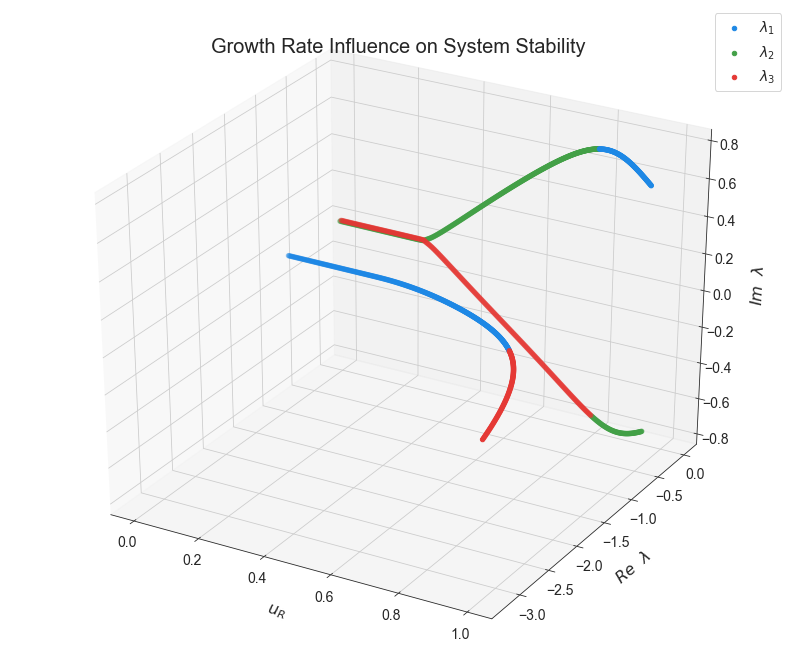

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(u_R_vals, real_parts[0],imag_parts[0], label=r'$\lambda_1$')
ax.scatter(u_R_vals, real_parts[1],imag_parts[1], label=r'$\lambda_2$')
ax.scatter(u_R_vals, real_parts[2],imag_parts[2], label=r'$\lambda_3$')
ax.legend(loc='best')
ax.set_xlabel(r'$u_R$', labelpad=14)
ax.set_ylabel(r'$Re\ \ \lambda$', labelpad=14)
ax.set_zlabel(r'$Im\ \ \lambda$', labelpad=14)
ax.set_title('Growth Rate Influence on System Stability')


The main thing to notice with this graph is that before u_R ~0.267 all the eigenvalues are purely real numbers so you don't get any oscillations. These real components turn out to be negative (see the next graph) so the system asymptotically goes to a stable equilibrium. After u_R ~0.267, there is at least one eigenvalue with an imaginary component so the system will oscillate (either it is a damped or expanding oscillation).

After u_R ~0.805, you have two eigenvalues with imaginary components still (even though they jumped and switched places: see first graph below). In terms of real components, all three eigenvalues have negative components so it is a damped oscillation going to stable equilibriums. Since lambda3 becomes more and more negative (2nd graph below), the oscillations dampens quicker as you increase u_R.

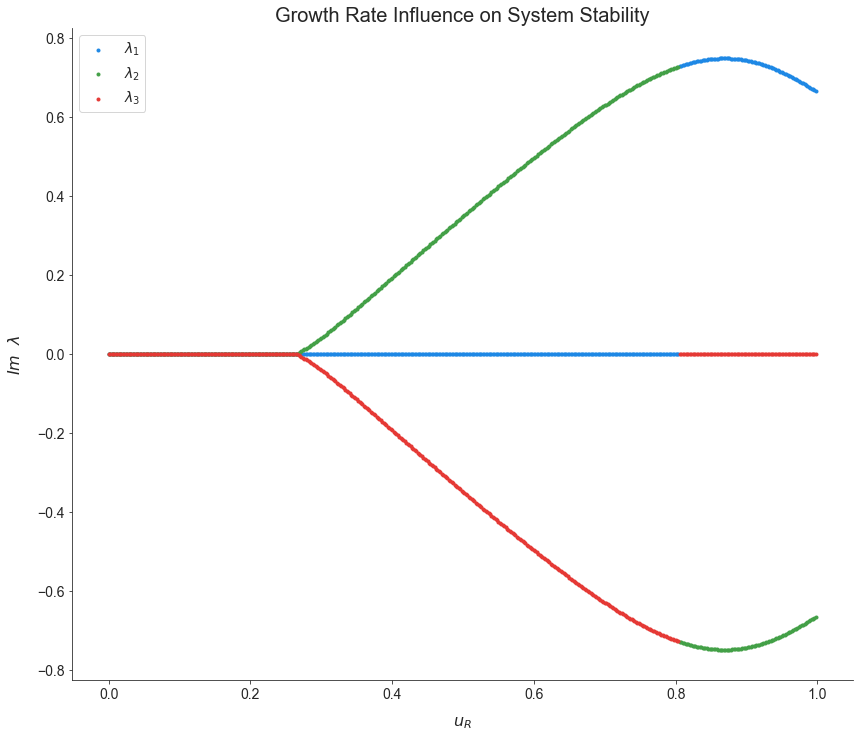

In [13]:

fig, ax = plt.subplots()
ax.scatter(u_R_vals, imag_parts[0], label=r'$\lambda_1$', marker='.')
ax.scatter(u_R_vals, imag_parts[1], label=r'$\lambda_2$', marker='.')
ax.scatter(u_R_vals, imag_parts[2], label=r'$\lambda_3$', marker='.')
ax.set_xlabel(r'$u_R$', labelpad=14)
ax.set_ylabel(r'$Im\ \ \lambda$', labelpad=14)
ax.legend(loc='best')
ax.set_title('Growth Rate Influence on System Stability')
sns.despine()


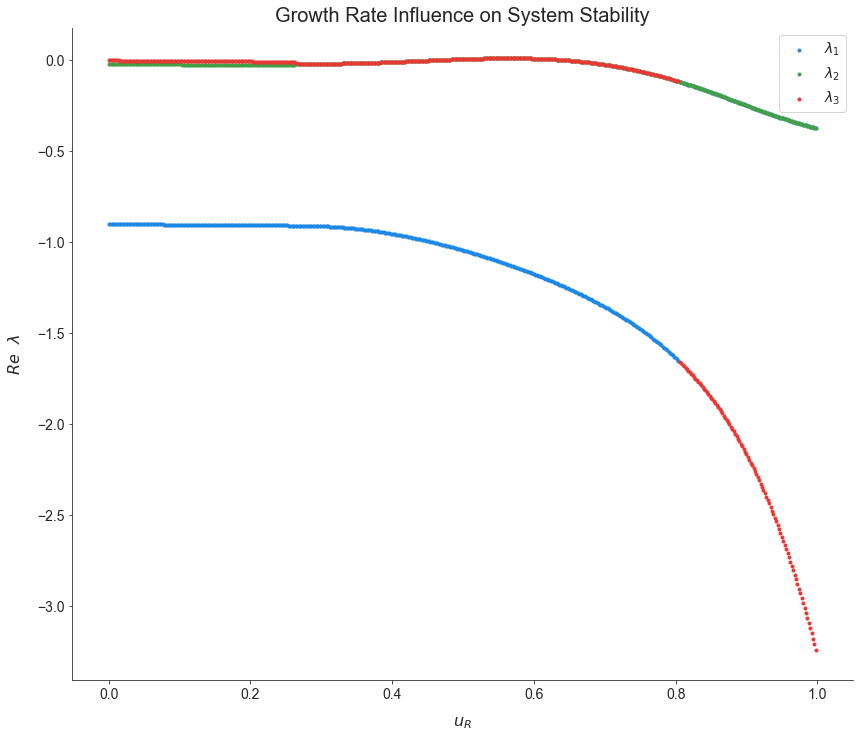

In [15]:

fig, ax = plt.subplots()
ax.scatter(u_R_vals, real_parts[0], label=r'$\lambda_1$', marker='.')
ax.scatter(u_R_vals, real_parts[1], label=r'$\lambda_2$', marker='.')
ax.scatter(u_R_vals, real_parts[2], label=r'$\lambda_3$', marker='.')
ax.set_xlabel(r'$u_R$', labelpad=14)
ax.set_ylabel(r'$Re\ \ \lambda$', labelpad=14)
ax.legend(loc='best')
ax.set_title('Growth Rate Influence on System Stability')
sns.despine()



At u_R ~0.457 and ~0.647 (critical points) the real parts of lambda2 and lambda3 become equal to zero so you get a hopf bifurcation. At those points you get perfect sustained oscillations. When lambda2 and lambda3 have negative real components then you get the first state of a supercritical hopf (see my first graph) where everything just spirals towards 1 stable point. When lambda2 and lambda3 have positive real components then you get the 2nd state (see my second graph) where the center point is an unstable point and there is a stable orbit that elements from both inside and outside spiral towards.

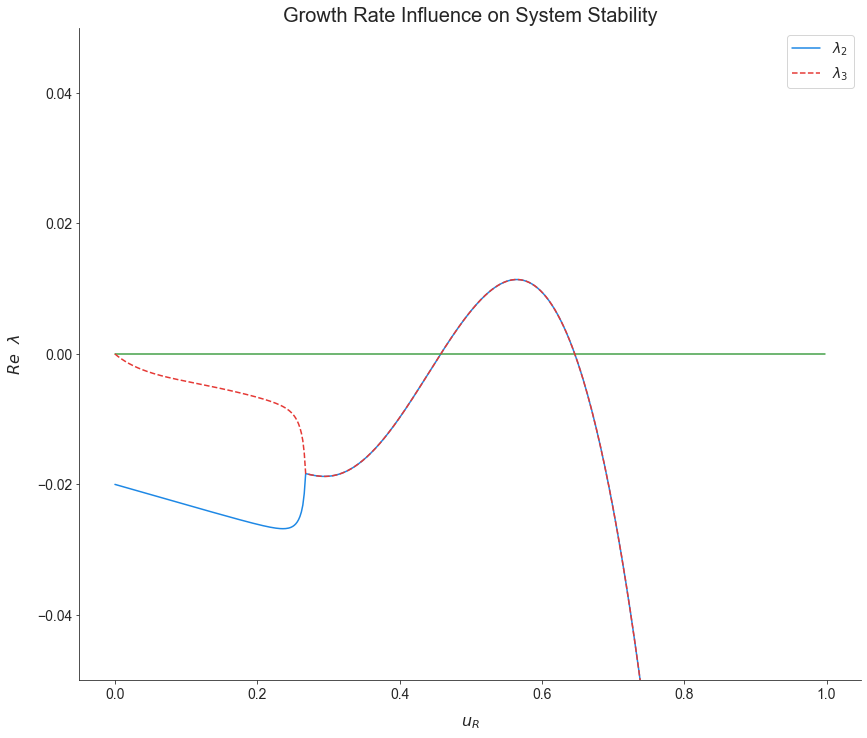

In [16]:
fig, ax = plt.subplots()
zero_line = np.zeros(len(real_parts[0]))
ax.plot(u_R_vals, real_parts[1], label=r'$\lambda_2$')
ax.plot(u_R_vals, zero_line)
ax.plot(u_R_vals, real_parts[2], label=r'$\lambda_3$', linestyle='--')
ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$u_R$', labelpad=14)
ax.set_ylabel(r'$Re\ \ \lambda$', labelpad=14)
ax.legend(loc='best')
ax.set_title('Growth Rate Influence on System Stability')
sns.despine()


In [17]:

hopf_table = pd.DataFrame()
hopf_table['u_R'] = u_R_vals
hopf_table['real0'] = real_parts[0]
hopf_table['imag0'] = imag_parts[0]
hopf_table['real1'] = real_parts[1]
hopf_table['imag1'] = imag_parts[1]
hopf_table['real2'] = real_parts[2]
hopf_table['imag2'] = imag_parts[2]
hopf_table

,u_R,real0,imag0,real1,imag1,real2,imag2
0,0.000,-0.900000,0.000000,-0.020000,0.000000,-0.000001,0.000000
1,0.002,-0.900062,0.000000,-0.020062,0.000000,-0.000188,0.000000
2,0.004,-0.900125,0.000000,-0.020125,0.000000,-0.000361,0.000000
3,0.006,-0.900187,0.000000,-0.020187,0.000000,-0.000525,0.000000
4,0.008,-0.900250,0.000000,-0.020250,0.000000,-0.000681,0.000000
5,0.010,-0.900312,0.000000,-0.020312,0.000000,-0.000830,0.000000
6,0.012,-0.900374,0.000000,-0.020374,0.000000,-0.000972,0.000000
7,0.014,-0.900437,0.000000,-0.020437,0.000000,-0.001109,0.000000
8,0.016,-0.900499,0.000000,-0.020499,0.000000,-0.001240,0.000000
9,0.018,-0.900562,0.000000,-0.020561,0.000000,-0.001366,0.000000


Text(0.5, 0.92, 'Phase Portrait for $u_R < (u_R)_c$')

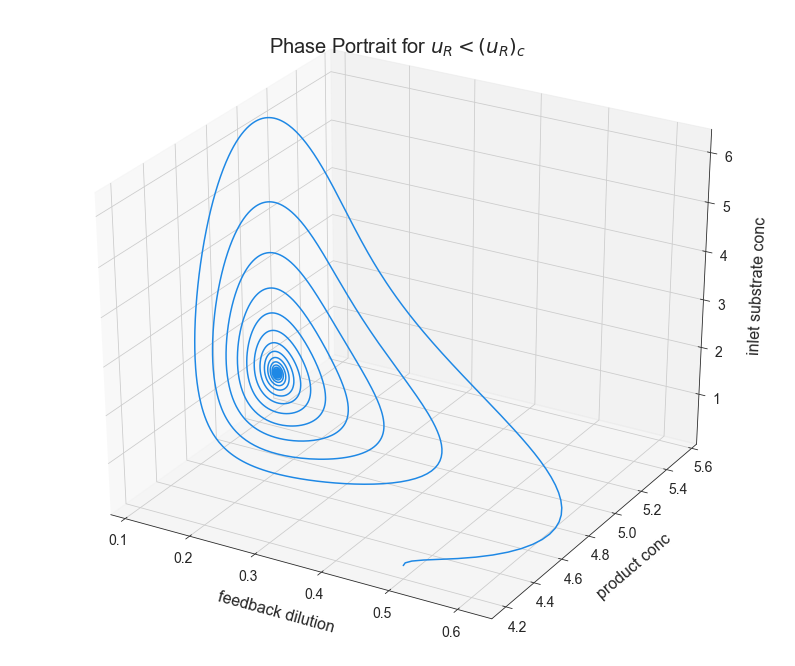

In [23]:
params = dict(params0)
params['u_R'] = 0.4

v0 = [0.5, 4.2, 0.2]
t = np.linspace(0, 5000, 50000)
sol = odeint(growth_dynamics, v0, t, args=(params,))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(sol[:,0],sol[:,1],sol[:,2])
ax.set_xlabel('feedback dilution', labelpad=14)
ax.set_ylabel('product conc', labelpad=14)
ax.set_zlabel('inlet substrate conc', labelpad=14)
ax.set_title(r"Phase Portrait for $u_R < (u_R)_c$")


Text(0.5, 0.92, 'Phase Portrait for $u_R > (u_R)_c$')

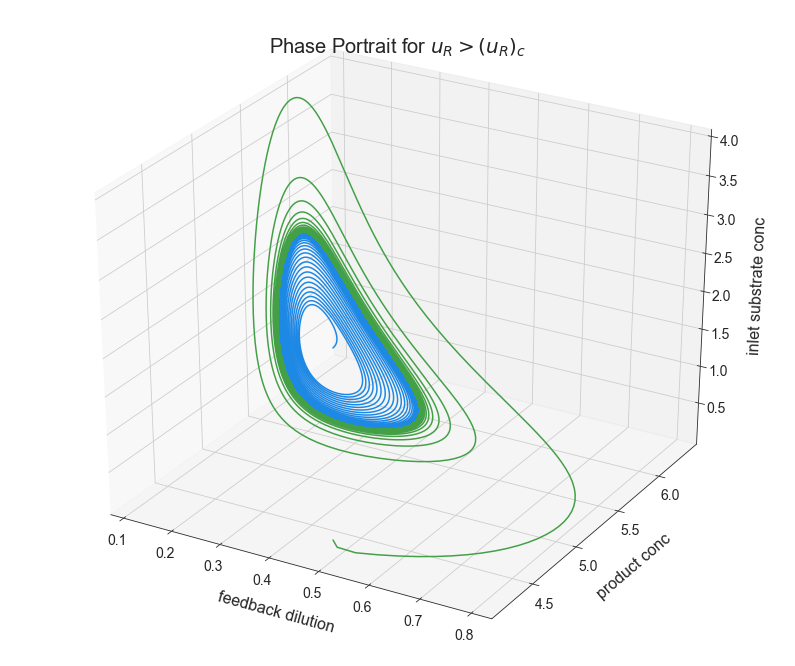

In [26]:

params = dict(params0)
params['u_R'] = 0.48

# Starting point inside the orbit
v0 = [0.18, 5.9, 0.70]
t = np.linspace(0, 5000, 50000)
sol = odeint(growth_dynamics, v0, t, args=(params,))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(sol[:,0],sol[:,1],sol[:,2])

# Starting point outside the orbit
v0 = [0.5, 4.2, 0.2]
t = np.linspace(0, 5000, 50000)
sol = odeint(growth_dynamics, v0, t, args=(params,))
ax.plot3D(sol[:,0],sol[:,1],sol[:,2])
ax.set_xlabel('feedback dilution', labelpad=14)
ax.set_ylabel('product conc', labelpad=14)
ax.set_zlabel('inlet substrate conc', labelpad=14)
ax.set_title(r"Phase Portrait for $u_R > (u_R)_c$")
